In [ ]:
!pip install "chronos-forecasting>=2.0"

In [ ]:
import os
import sys
import time
import warnings

from chronos import Chronos2Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import torch
from tqdm import tqdm
import xgboost as xgb

In [ ]:
warnings.filterwarnings("ignore", module="chronos")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*pin_memory.*")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_MODE = True

BASE_PATH = '..'
INPUT_FILE = os.path.join(BASE_PATH, 'train.csv')

In [ ]:
LEAD_TIME_MEAN = 14
LEAD_TIME_STD = 3
SERVICE_LEVEL = 0.97
HOLDING_COST = 0.05
STOCKOUT_COST = 45
ORDERING_COST = 20

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {DEVICE.upper()}")

Running on device: CUDA


In [ ]:
def plot_adf_benchmark(adf_stat, critical_values, title='Stationarity Test Result'):
    """Visualize ADF test results comparing test statistic against critical values."""
    labels = ['ADF Statistic'] + list(critical_values.keys())
    values = [adf_stat] + list(critical_values.values())
    colors = ['#1f77b4'] + ['#d62728' for _ in critical_values]

    plt.figure(figsize=(10, 6))

    bars = plt.barh(labels, values, color=colors, alpha=0.8)

    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.4f}',
                 va='center', ha='left' if bar.get_width() > 0 else 'right',
                 fontweight='bold')

    plt.axvline(critical_values['5%'], color='green', linestyle='--', linewidth=2, label='5% Confidence Threshold')

    plt.title(title, fontsize=14)
    plt.xlabel('Test Statistic Value (More Negative is Better)')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)

    status = 'STATIONARY' if adf_stat < critical_values['5%'] else 'NON-STATIONARY'
    plt.figtext(0.5, -0.05, f'Result: {status}',
                ha='center', fontsize=12, bbox={'facecolor':'orange', 'alpha':0.2, 'pad':5})

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_safety_stock(mean_forecast, forecast_error_std_dev):
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    # Compound Variance Formula: Sigma_DL = sqrt( L * Sigma_D^2 + D^2 * Sigma_L^2 )
    demand_variance_component = LEAD_TIME_MEAN * (forecast_error_std_dev ** 2)
    supply_variance_component = (mean_forecast ** 2) * (LEAD_TIME_STD ** 2)
    combined_std_dev = np.sqrt(demand_variance_component + supply_variance_component)

    return z_score * combined_std_dev

In [ ]:
def calculate_policy(mean_forecast, forecast_error_std_dev):
    """Calculate inventory policy parameters accounting for Demand and Supply variability."""
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    safety_stock = calculate_safety_stock(mean_forecast, forecast_error_std_dev)

    reorder_point = (mean_forecast * LEAD_TIME_MEAN) + safety_stock

    annual_demand = mean_forecast * 365

    order_quantity = np.sqrt((2 * annual_demand * ORDERING_COST) / (HOLDING_COST * 365))

    return {
        'safety_stock': round(safety_stock, 2),
        'reorder_point': round(reorder_point, 2),
        'order_quantity': round(order_quantity, 2)
    }

In [ ]:
def run_dynamic_simulation(forecast_series, actual_demand, forecast_error_std_dev, verbose=False):
    """Simulate inventory operations with Stochastic Lead Times."""
    n_days = len(actual_demand)
    z_score = stats.norm.ppf(SERVICE_LEVEL)

    avg_daily_demand = np.mean(forecast_series)

    safety_stock = calculate_safety_stock(avg_daily_demand, forecast_error_std_dev)

    order_quantity = np.sqrt((2 * avg_daily_demand * 365 * ORDERING_COST) / (HOLDING_COST * 365))

    order_quantity = max(1.0, round(order_quantity, 0))

    initial_lookahead = sum(forecast_series[:LEAD_TIME_MEAN])
    inventory = initial_lookahead + safety_stock

    pipeline_orders = [] # tuples of (arrival_day, qty)

    total_holding_cost = 0.0
    total_stockout_cost = 0.0
    total_lost_sales = 0.0

    if verbose:
        print(f'\nDynamic Simulation Start')
        print(f'SS (Dynamic): {safety_stock:.2f} | EOQ: {order_quantity}')
        print(f'{"Day":<5} | {"Fcst(LT)":<9} | {"DynROP":<8} | {"InvPos":<8} | {"NetInv":<8} | {"Demand":<8} | {"Lost":<6} | {"Act.LT":<6}')
        print('-' * 98)

    for day in range(n_days):
        arrived_qty = sum([qty for arr_day, qty in pipeline_orders if arr_day == day])
        inventory += arrived_qty
        pipeline_orders = [o for o in pipeline_orders if o[0] > day]

        demand = actual_demand[day]
        if inventory >= demand:
            sales = demand
            inventory -= demand
            lost_sales = 0
        else:
            sales = inventory
            lost_sales = demand - inventory
            inventory = 0

        total_lost_sales += lost_sales

        daily_holding = inventory * HOLDING_COST
        daily_stockout = lost_sales * STOCKOUT_COST
        total_holding_cost += daily_holding
        total_stockout_cost += daily_stockout

        # reviewing ordering
        start_idx = day + 1
        end_idx = start_idx + LEAD_TIME_MEAN

        if end_idx <= n_days:
            expected_demand_during_lt = sum(forecast_series[start_idx : end_idx])
        else:
            available_days = n_days - start_idx
            if available_days > 0:
                known = sum(forecast_series[start_idx:])
                # ordering partially for the period after the test window
                padded = avg_daily_demand * (LEAD_TIME_MEAN - available_days)
                expected_demand_during_lt = known + padded
            else:
                # ordering for the period after the test window
                expected_demand_during_lt = avg_daily_demand * LEAD_TIME_MEAN

        dynamic_rop = expected_demand_during_lt + safety_stock

        on_order_qty = sum([qty for _, qty in pipeline_orders])
        inventory_position = inventory + on_order_qty

        sampled_lt_str = '-'
        if inventory_position <= dynamic_rop:
            # sample lead time
            actual_lt_float = np.random.normal(LEAD_TIME_MEAN, LEAD_TIME_STD)
            actual_lt = int(max(1, round(actual_lt_float)))

            arrival_day = day + actual_lt
            pipeline_orders.append((arrival_day, order_quantity))
            sampled_lt_str = str(actual_lt)

        if verbose:
             print(f'{day:<5} | {expected_demand_during_lt:<9.1f} | {dynamic_rop:<8.1f} | {inventory_position:<8.1f} | {inventory:<8.1f} | {demand:<8.1f} | {lost_sales:<6.1f} | {sampled_lt_str:<6}')

    total_cost = total_holding_cost + total_stockout_cost
    service_level = 1 - (total_lost_sales / (sum(actual_demand)+0.01))

    if verbose:
        print('\n')
        print(f'Total Holding:  ${total_holding_cost:,.2f}')
        print(f'Total Stockout: ${total_stockout_cost:,.2f}')
        print(f'TOTAL COST:     ${total_cost:,.2f}')
        print(f'Service Level:  {service_level:.2%}')
        print('\n')

    return round(total_holding_cost, 2), round(total_stockout_cost, 2), round(total_cost, 2), service_level

In [ ]:
def get_xgboost_forecast(train_df, test_df, verbose=True):
    """Generate forecast using XGBoost with date features and YoLag."""

    def create_features(df):
        df = df.copy()
        df['day_of_week'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['year'] = df['date'].dt.year
        return df

    X_train = create_features(train_df)

    # add the sales from a year ago as a feature
    lookup = train_df[['date', 'sales']].copy()
    lookup['match_date'] = lookup['date'] + pd.Timedelta(days=365)

    X_train = X_train.merge(lookup[['match_date', 'sales']],
                            left_on='date', right_on='match_date',
                            how='left', suffixes=('', '_lag365'))
    X_train.rename(columns={'sales_lag365': 'lag_365'}, inplace=True)

    X_test = create_features(test_df)
    X_test = X_test.merge(lookup[['match_date', 'sales']],
                          left_on='date', right_on='match_date',
                          how='left', suffixes=('', '_lag365'))
    X_test.rename(columns={'sales_lag365': 'lag_365'}, inplace=True)

    # Drop rows where lag is unavailable (first year of training)
    X_train.dropna(subset=['lag_365'], inplace=True)

    features = ['day_of_week', 'month', 'day_of_year', 'year', 'lag_365']
    target = 'sales'

    xgb_device = "cuda" if DEVICE == "cuda" else "cpu"

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01,
                             max_depth=5, early_stopping_rounds=50, n_jobs=-1,
                             device=xgb_device)

    # validation split
    split_idx = int(len(X_train) * 0.9)
    X_tr = X_train.iloc[:split_idx]
    X_val = X_train.iloc[split_idx:]

    model.fit(X_tr[features], X_tr[target],
              eval_set=[(X_tr[features], X_tr[target]), (X_val[features], X_val[target])],
              verbose=False)

    forecast = model.predict(X_test[features])

    # Calculate residuals on validation set to estimate uncertainty
    val_preds = model.predict(X_val[features])
    residuals = X_val[target] - val_preds
    sigma = np.sqrt(np.mean(residuals ** 2))

    if verbose:
        print(f"XGBoost Trained. Validation RMSE: {sigma:.2f}")

    return forecast, sigma

In [ ]:
def get_trend_adjusted_baseline(train_df, valid_df, verbose=True):
    """Generate baseline forecast using seasonal patterns adjusted for recent trends."""
    last_date = train_df['date'].max()
    split_date = last_date - pd.Timedelta(days=90)

    # seasonality
    history_df = train_df[train_df['date'] <= split_date].copy()
    history_df['day_of_year'] = history_df['date'].dt.dayofyear
    history_df.loc[history_df['day_of_year'] == 366, 'day_of_year'] = 365
    seasonal_profile = history_df.groupby('day_of_year')['sales'].mean()

    # trend
    recent_vol = train_df[train_df['date'] > split_date]['sales'].mean()
    start_prev = split_date - pd.Timedelta(days=365)
    end_prev = last_date - pd.Timedelta(days=365)

    prev_vol_mask = (train_df['date'] > start_prev) & (train_df['date'] <= end_prev)
    prev_vol = train_df[prev_vol_mask]['sales'].mean()

    trend_factor = recent_vol / prev_vol if prev_vol > 0 else 1.0
    trend_factor = min(max(trend_factor, 0.8), 1.2)

    # forecast
    valid_df['day_of_year'] = valid_df['date'].dt.dayofyear
    valid_df.loc[valid_df['day_of_year'] == 366, 'day_of_year'] = 365
    baseline_forecast = valid_df['day_of_year'].map(seasonal_profile).values * trend_factor

    # accuracy
    train_check = train_df.copy()
    train_check['day_of_year'] = train_check['date'].dt.dayofyear
    train_check.loc[train_check['day_of_year'] == 366, 'day_of_year'] = 365
    train_forecast = train_check['day_of_year'].map(seasonal_profile) * trend_factor
    residuals = train_check['sales'] - train_forecast
    rmse = np.sqrt(np.mean(residuals[-365:] ** 2))

    return baseline_forecast, rmse, trend_factor

In [ ]:
def run_analysis_for_pair(train_df, test_df, pipeline, verbose=True, plot=True):
    """Run full analysis comparing Baseline vs XGBoost vs Chronos 2."""
    results = {}
    actual_demand = test_df['sales'].values

    if verbose: print('\n--- 1. Baseline Simulation ---')
    baseline_fcst, baseline_std, _ = get_trend_adjusted_baseline(train_df, test_df, verbose=verbose)
    baseline_holding, baseline_stockout, baseline_cost, baseline_sl = run_dynamic_simulation(baseline_fcst, actual_demand, baseline_std, verbose=verbose)

    results['baseline_holding_cost'] = baseline_holding
    results['baseline_stockout_cost'] = baseline_stockout
    results['baseline_cost'] = baseline_cost
    results['baseline_sl'] = baseline_sl

    if verbose: print('\n--- 2. XGBoost Simulation ---')
    xgb_fcst, xgb_std = get_xgboost_forecast(train_df, test_df, verbose=verbose)

    if plot:
        plt.figure(figsize=(15, 6))
        plt.plot(test_df['date'], actual_demand, label='Actual', color='black', alpha=0.3)
        plt.plot(test_df['date'], baseline_fcst, label='Baseline', color='green', linestyle='--')
        plt.plot(test_df['date'], xgb_fcst, label='XGBoost', color='orange', linewidth=2)
        plt.title('Forecast Comparison: Baseline vs XGBoost')
        plt.legend()
        plt.show()

    xgb_holding, xgb_stockout, xgb_cost, xgb_sl = run_dynamic_simulation(xgb_fcst, actual_demand, xgb_std, verbose=verbose)
    results['xgb_holding_cost'] = xgb_holding
    results['xgb_stockout_cost'] = xgb_stockout
    results['xgb_cost'] = xgb_cost
    results['xgb_sl'] = xgb_sl

    if verbose: print('\n--- 3. Chronos 2 Simulation ---')
    context_tensor = torch.tensor(train_df['sales'].values)
    context_tensor = context_tensor.unsqueeze(0).unsqueeze(0) # Make it (1, 1, Length)
    forecast_result = pipeline.predict(context_tensor, len(test_df))
    batch_item_forecast = forecast_result[0]
    forecast_samples = batch_item_forecast.cpu().numpy()
    if forecast_samples.ndim == 3:
        forecast_samples = forecast_samples[0]

    daily_means = np.mean(forecast_samples, axis=0)

    # chronos sigma calculation
    calibration_window = 60
    train_sales = train_df['sales'].values

    train_context_tensor = torch.tensor(train_sales[:-calibration_window])
    train_context_tensor = train_context_tensor.unsqueeze(0).unsqueeze(0)

    calib_fcst = pipeline.predict(train_context_tensor, calibration_window)

    calib_samples = calib_fcst[0].cpu().numpy()
    if calib_samples.ndim == 3:
        calib_samples = calib_samples[0]

    calib_mean = np.mean(calib_samples, axis=0)
    calib_residuals = train_sales[-calibration_window:] - calib_mean
    chronos_sigma = np.sqrt(np.mean(calib_residuals ** 2))

    chronos_holding, chronos_stockout, chronos_cost, chronos_sl = run_dynamic_simulation(daily_means, actual_demand, chronos_sigma, verbose=verbose)
    results['chronos_holding_cost'] = chronos_holding
    results['chronos_stockout_cost'] = chronos_stockout
    results['chronos_cost'] = chronos_cost
    results['chronos_sl'] = chronos_sl

    # final comparison
    xgb_savings = baseline_cost - xgb_cost
    xgb_pct = (xgb_savings / baseline_cost * 100) if baseline_cost > 0 else 0

    chronos_savings = baseline_cost - chronos_cost
    chronos_pct = (chronos_savings / baseline_cost * 100) if baseline_cost > 0 else 0

    chronos_vs_xgb_savings = xgb_cost - chronos_cost
    chronos_vs_xgb_pct = (chronos_vs_xgb_savings / xgb_cost * 100) if xgb_cost > 0 else 0

    if verbose:
        print('FINAL RESULTS')
        print(f'Baseline Cost: ${baseline_cost:,.2f}')
        print(f'XGBoost Cost:  ${xgb_cost:,.2f}  (Savings vs Base: ${xgb_savings:,.0f} | {xgb_pct:.1f}%)')
        print(f'Chronos 2 Cost: ${chronos_cost:,.2f}  (Savings vs Base: ${chronos_savings:,.0f} | {chronos_pct:.1f}%)')
        print(f'                                  (Savings vs XGB:  ${chronos_vs_xgb_savings:,.0f} | {chronos_vs_xgb_pct:.1f}%)')

    return results

In [ ]:
print('Phase 1: Data Preparation')
print(f'Loading raw data from {INPUT_FILE}...')
df_all = pd.read_csv(INPUT_FILE)
df_all.columns = df_all.columns.str.strip()
if 'store' not in df_all.columns and 'strore' in df_all.columns:
    df_all.rename(columns={'strore': 'store'}, inplace=True)
df_all['date'] = pd.to_datetime(df_all['date'])

print(f'Initializing Chronos 2 Pipeline on {DEVICE.upper()}...')
pipeline = Chronos2Pipeline.from_pretrained(
    'amazon/chronos-2',
    device_map=DEVICE,
    torch_dtype=torch.bfloat16,
)

if BATCH_MODE:
    print('\nBATCH MODE ENABLED')
    pairs = df_all[['store', 'item']].drop_duplicates().values
    print(f'Found {len(pairs)} store-item pairs.')

    results_list = []
    start_time = time.time()

    for store, item in tqdm(pairs, desc="Processing Pairs", unit="pair"):

        subset = df_all[(df_all['store'] == store) & (df_all['item'] == item)].sort_values('date').copy()
        train_subset = subset[subset['date'].dt.year < 2017].copy()
        test_subset = subset[subset['date'].dt.year == 2017].copy()

        try:
            res = run_analysis_for_pair(train_subset, test_subset, pipeline, verbose=False, plot=False)
            res['store'] = store
            res['item'] = item
            results_list.append(res)
        except Exception as e:
            tqdm.write(f'Error processing Store {store}, Item {item}: {e}')

    results_df = pd.DataFrame(results_list)

    cols = ['baseline_cost', 'xgb_cost', 'chronos_cost']
    avgs = results_df[cols].mean()

    print('\n\nBATCH RESULTS (Averages)')
    print(f'Baseline Cost:  ${avgs["baseline_cost"]:,.2f}')
    print(f'XGBoost Cost:   ${avgs["xgb_cost"]:,.2f}')
    print(f'Chronos 2 Cost: ${avgs["chronos_cost"]:,.2f}')

        results_df.to_csv(os.path.join(BASE_PATH, 'batch_results_xgb_c2.csv'), index=False)
else:
    print('\n--- SINGLE ITEM MODE ---')
    subset = df_all[(df_all['store'] == 1) & (df_all['item'] == 1)].sort_values('date').copy()
    train_subset = subset[subset['date'].dt.year < 2017].copy()
    test_subset = subset[subset['date'].dt.year == 2017].copy()

    run_analysis_for_pair(train_subset, test_subset, pipeline, verbose=True, plot=True)

Phase 1: Data Preparation
Loading raw data from /content/drive/My Drive/Projects/inventory/train.csv...
Initializing Chronos 2 Pipeline on CUDA...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]


BATCH MODE ENABLED
Found 500 store-item pairs.


Processing Pairs:   0%|          | 0/500 [00:00<?, ?pair/s]/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [01:10:08] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
Processing Pairs: 100%|██████████| 500/500 [05:57<00:00,  1.40pair/s]




BATCH RESULTS (Averages)
Baseline Cost:  $11,225.41
XGBoost Cost:   $10,590.82
Chronos 2 Cost: $9,245.33



             EXECUTIVE PERFORMANCE SUMMARY             

1. GLOBAL IMPACT (Total Inventory Costs)
   Baseline:    $5,612,706 (Holding: $3,355,236, Stockout: $2,257,470)
   XGBoost:     $5,295,411 (Holding: $3,622,392, Stockout: $1,673,019)
   Chronos 2:   $4,622,665 (Holding: $4,302,571, Stockout: $320,094)

2. OPERATIONAL VIEW (Average Cost Per Item)
   Baseline:    $11,225.41 / item
   XGBoost:     $10,590.82 / item
   Chronos 2:   $9,245.33 / item

3. COST SAVINGS ANALYSIS
   XGBoost vs Baseline:
      Total Savings:    $317,295
      Avg per Item:     $634.59
      Reduction:        5.65%
   Chronos 2 vs Baseline:
      Total Savings:    $990,041
      Avg per Item:     $1,980.08
      Reduction:        17.64%
   Chronos 2 vs XGBoost:
      Total Savings:    $672,746
      Avg per Item:     $1,345.49
      Reduction:        12.70%

4. SERVICE LEVELS (Target: 97%)
   Baseline:    99.46%
   XGBoost:     99.53%
   Chronos 2:   99.91%



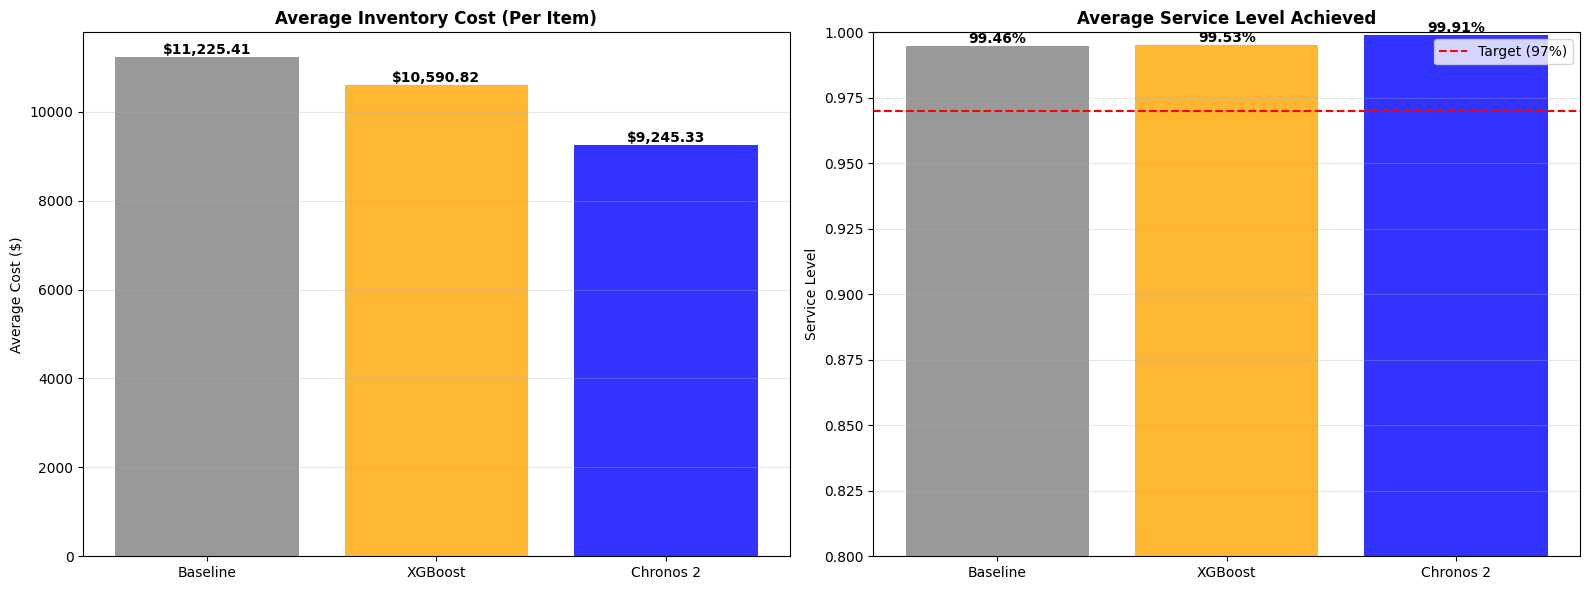

In [ ]:
if 'results_df' not in locals():
    results_path = os.path.join(BASE_PATH, 'batch_results_xgb_c2.csv')
    results_df = pd.read_csv(results_path)
    print(f"Loaded results from {results_path}")

# aggregates
total_baseline = results_df['baseline_cost'].sum()
total_xgb = results_df['xgb_cost'].sum()
total_chronos = results_df['chronos_cost'].sum()

total_baseline_holding = results_df['baseline_holding_cost'].sum()
total_baseline_stockout = results_df['baseline_stockout_cost'].sum()
total_xgb_holding = results_df['xgb_holding_cost'].sum()
total_xgb_stockout = results_df['xgb_stockout_cost'].sum()
total_chronos_holding = results_df['chronos_holding_cost'].sum()
total_chronos_stockout = results_df['chronos_stockout_cost'].sum()

# averages
avg_baseline = results_df['baseline_cost'].mean()
avg_xgb = results_df['xgb_cost'].mean()
avg_chronos = results_df['chronos_cost'].mean()

avg_sl_baseline = results_df['baseline_sl'].mean()
avg_sl_xgb = results_df['xgb_sl'].mean()
avg_sl_chronos = results_df['chronos_sl'].mean()

# savings %
pct_sav_xgb = (total_baseline - total_xgb) / total_baseline
pct_sav_chronos = (total_baseline - total_chronos) / total_baseline
pct_sav_chronos_vs_xgb = (total_xgb - total_chronos) / total_xgb

print("\n" + "="*60)
print("             EXECUTIVE PERFORMANCE SUMMARY             ")
print("="*60)

print(f"\n1. GLOBAL IMPACT (Total Inventory Costs)")
print(f"   Baseline:    ${total_baseline:,.0f} (Holding: ${total_baseline_holding:,.0f}, Stockout: ${total_baseline_stockout:,.0f})")
print(f"   XGBoost:     ${total_xgb:,.0f} (Holding: ${total_xgb_holding:,.0f}, Stockout: ${total_xgb_stockout:,.0f})")
print(f"   Chronos 2:   ${total_chronos:,.0f} (Holding: ${total_chronos_holding:,.0f}, Stockout: ${total_chronos_stockout:,.0f})")

print(f"\n2. OPERATIONAL VIEW (Average Cost Per Item)")
print(f"   Baseline:    ${avg_baseline:,.2f} / item")
print(f"   XGBoost:     ${avg_xgb:,.2f} / item")
print(f"   Chronos 2:   ${avg_chronos:,.2f} / item")

print(f"\n3. COST SAVINGS ANALYSIS")
print(f"   XGBoost vs Baseline:")
print(f"      Total Savings:    ${total_baseline - total_xgb:,.0f}")
print(f"      Avg per Item:     ${avg_baseline - avg_xgb:,.2f}")
print(f"      Reduction:        {pct_sav_xgb:.2%}")

print(f"   Chronos 2 vs Baseline:")
print(f"      Total Savings:    ${total_baseline - total_chronos:,.0f}")
print(f"      Avg per Item:     ${avg_baseline - avg_chronos:,.2f}")
print(f"      Reduction:        {pct_sav_chronos:.2%}")

print(f"   Chronos 2 vs XGBoost:")
print(f"      Total Savings:    ${total_xgb - total_chronos:,.0f}")
print(f"      Avg per Item:     ${avg_xgb - avg_chronos:,.2f}")
print(f"      Reduction:        {pct_sav_chronos_vs_xgb:.2%}")

print(f"\n4. SERVICE LEVELS (Target: {SERVICE_LEVEL:.0%})")
print(f"   Baseline:    {avg_sl_baseline:.2%}")
print(f"   XGBoost:     {avg_sl_xgb:.2%}")
print(f"   Chronos 2:   {avg_sl_chronos:.2%}")
print("="*60 + "\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# average cost per Item
costs = [avg_baseline, avg_xgb, avg_chronos]
labels = ['Baseline', 'XGBoost', 'Chronos 2']
colors = ['gray', 'orange', 'blue']

bars = ax[0].bar(labels, costs, color=colors, alpha=0.8)
ax[0].set_title('Average Inventory Cost (Per Item)', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Average Cost ($)')
ax[0].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2., height,
               f'${height:,.2f}',
               ha='center', va='bottom', fontweight='bold')

# service levels
sls = [avg_sl_baseline, avg_sl_xgb, avg_sl_chronos]
bars_sl = ax[1].bar(labels, sls, color=colors, alpha=0.8)
ax[1].axhline(y=SERVICE_LEVEL, color='red', linestyle='--', label=f'Target ({SERVICE_LEVEL:.0%})')
ax[1].set_title('Average Service Level Achieved', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Service Level')
ax[1].set_ylim(0.8, 1.0)
ax[1].legend()
ax[1].grid(axis='y', alpha=0.3)

for bar in bars_sl:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2%}',
               ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Sampling 50 items to estimate global forecast bias...


Calculating Bias: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


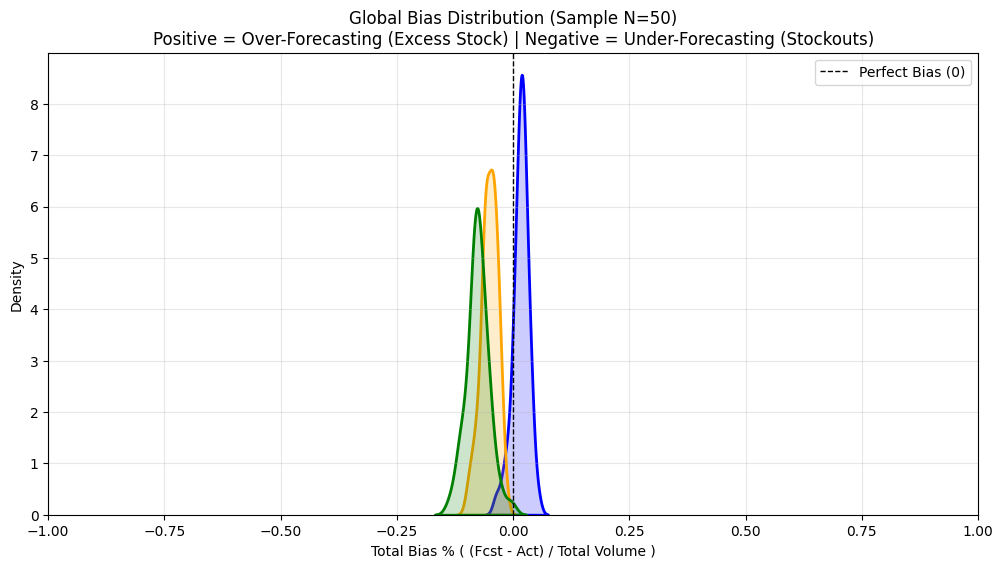


BIAS SUMMARY STATISTICS (Mean % Error)
      Baseline  XGBoost  Chronos
mean    -7.65%   -5.17%   +1.58%
std     +2.41%   +1.75%   +1.67%
50%     -7.68%   -4.93%   +1.76%
--------------------------------------------------
INTERPRETATION:
 * Mean > 0:  The model systematically over-orders (High Holding Costs).
 * Mean < 0:  The model systematically under-orders (Stockout Risks).
 * Std Dev:   A lower value means the model is more consistent/reliable.


In [ ]:
n_samples = 50
all_pairs = df_all[['store', 'item']].drop_duplicates().values
indices = np.random.choice(len(all_pairs), n_samples, replace=False)
sample_pairs = all_pairs[indices]

print(f"Sampling {n_samples} items to estimate global forecast bias...")

bias_results = []

# forecasting
for store, item in tqdm(sample_pairs, desc="Calculating Bias"):

    subset = df_all[(df_all['store'] == store) & (df_all['item'] == item)].sort_values('date').copy()
    train_df = subset[subset['date'].dt.year < 2017].copy()
    test_df = subset[subset['date'].dt.year == 2017].copy()

    if len(train_df) < 365 or len(test_df) == 0: continue

    actuals = test_df['sales'].values
    total_vol = np.sum(actuals) + 1e-6

    base_fcst, _, _ = get_trend_adjusted_baseline(train_df, test_df, verbose=False)
    bias_base = np.sum(base_fcst - actuals)

    xgb_fcst, _ = get_xgboost_forecast(train_df, test_df, verbose=False)
    bias_xgb = np.sum(xgb_fcst - actuals)

    context = torch.tensor(train_df['sales'].values).unsqueeze(0).unsqueeze(0)
    fcst_res = pipeline.predict(context, len(test_df))

    if isinstance(fcst_res, list): fcst_res = fcst_res[0]
    chronos_samples = fcst_res.cpu().numpy()
    if chronos_samples.ndim == 3: chronos_samples = chronos_samples[0]
    chronos_fcst = np.mean(chronos_samples, axis=0)

    bias_chronos = np.sum(chronos_fcst - actuals)

    # bias as %
    bias_results.append({
        'store': store,
        'item': item,
        'Baseline': bias_base / total_vol,
        'XGBoost': bias_xgb / total_vol,
        'Chronos': bias_chronos / total_vol
    })

bias_df = pd.DataFrame(bias_results)
melted = bias_df.melt(id_vars=['store', 'item'], var_name='Model', value_name='Bias_Pct')

plt.figure(figsize=(12, 6))

sns.kdeplot(data=melted, x='Bias_Pct', hue='Model', fill=True, alpha=0.2, linewidth=2,
            palette={'Baseline': 'green', 'XGBoost': 'orange', 'Chronos': 'blue'})

plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Perfect Bias (0)')
plt.title(f'Global Bias Distribution (Sample N={n_samples})\nPositive = Over-Forecasting (Excess Stock) | Negative = Under-Forecasting (Stockouts)')
plt.xlabel('Total Bias % ( (Fcst - Act) / Total Volume )')
plt.xlim(-1.0, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*50)
print("BIAS SUMMARY STATISTICS (Mean % Error)")
print("="*50)
print(bias_df[['Baseline', 'XGBoost', 'Chronos']].describe().loc[['mean', 'std', '50%']].to_string(float_format="{:±.2%}".format))
print("-" * 50)
print("INTERPRETATION:")
print(" * Mean > 0:  The model systematically over-orders (High Holding Costs).")
print(" * Mean < 0:  The model systematically under-orders (Stockout Risks).")
print(" * Std Dev:   A lower value means the model is more consistent/reliable.")
print("="*50)